In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# test_data_dir = '../examples/PyMPDATA_examples/Arabas_and_Farhat_2020/data/'
train_data_dir = './data/'

In [3]:
def load_data(filepath, idx):
    data = []
    for i in range(idx):
        advector = np.load(filepath + 'advector_' + str(i) + '.npy')
        advectee = np.load(filepath + 'advectee_' + str(i) + '.npy')
        flux = np.load(filepath + 'corrective_flux_' + str(i) + '.npy')
        data.append([advector, advectee, -flux])
        
    for i in range(idx):
        data[i][1] = pd.DataFrame(data[i][1]).fillna(method='ffill').values
        data[i][0] = pd.DataFrame(data[i][0]).fillna(method='ffill').values
        data[i][2] = pd.DataFrame(data[i][2]).fillna(method='ffill').values
        data[i][1] = pd.DataFrame(data[i][1]).fillna(method='bfill').values
        data[i][0] = pd.DataFrame(data[i][0]).fillna(method='bfill').values
        data[i][2] = pd.DataFrame(data[i][2]).fillna(method='bfill').values
    return data

In [4]:
data_train = load_data(train_data_dir, 2000)

In [5]:
def get_stencils(data, stencil_length):
    stencils= []
    max_advector = max(data[:][0].max() for data in data)
    max_advectee = max(data[:][1].max() for data in data)
    max_flux = max(data[:][2].max() for data in data)
    print(f"max_advector: {max_advector}, max_advectee: {max_advectee}, max_flux: {max_flux}")
    for i in range(len(data)):
        advector, advectee, flux = data[i]
        for j in range(0, len(data[i][1])-1):
            advectee_stencil = advectee[j-1:j+1]
            advector_stencil = advector[j-1:j+2]
            flux_stencil = flux[j]
            if np.isnan(advectee_stencil).any() or np.isnan(advector_stencil).any() or np.isnan(flux_stencil).any():
                continue
            try:
                assert advectee_stencil.shape[0] == stencil_length -1
                assert advector_stencil.shape[0] == stencil_length
            except:
                print(advectee_stencil.shape[0], advector_stencil.shape[0])
                print(advectee_stencil)
                print(advector_stencil)
                print(flux_stencil)
                print()
                continue
            # if any of the values are nan, skip this stencil
            advector_stencil = advector_stencil / max_advector
            # flatten the stencil
            advector_stencil = advector_stencil.flatten()
            advectee_stencil = advectee_stencil / max_advectee
            advectee_stencil = advectee_stencil.flatten()
            flux_stencil = flux_stencil / max_flux
            # flatten the stencil
            flux_stencil = flux_stencil.flatten()
            input_stencil = np.concatenate((advector_stencil, advectee_stencil), axis=0)

            stencils.append((input_stencil, flux_stencil[0]))
    return stencils

In [7]:
train_stencils = get_stencils(data_train, 3)

max_advector: 0.0007999697873453095, max_advectee: 1.9998721133365327, max_flux: 1.966778365763623e-06
0 0
[]
[]
[1.00508065e-06]

2 2
[[1.00003269]
 [1.        ]]
[[0.]
 [0.]]
[1.07091344e-06]

0 0
[]
[]
[1.00404277e-06]

2 2
[[1.00006432]
 [0.99996832]]
[[1.66533454e-19]
 [3.27505438e-05]]
[1.06984131e-06]

0 0
[]
[]
[1.00300752e-06]

2 2
[[1.00009591]
 [0.99993669]]
[[3.16806235e-08]
 [3.27346513e-05]]
[1.06877186e-06]

0 0
[]
[]
[1.00197487e-06]

2 2
[[1.00012744]
 [0.9999051 ]]
[[6.33137095e-08]
 [3.27187904e-05]]
[1.06770509e-06]

0 0
[]
[]
[1.00094483e-06]

2 2
[[1.00015893]
 [0.99987357]]
[[9.48993371e-08]
 [3.27029612e-05]]
[1.06664099e-06]

0 0
[]
[]
[9.99917382e-07]

2 2
[[1.00019038]
 [0.99984208]]
[[1.26437585e-07]
 [3.26871635e-05]]
[1.06557956e-06]

0 0
[]
[]
[9.98892524e-07]

2 2
[[1.00022177]
 [0.99981063]]
[[1.57928532e-07]
 [3.26713973e-05]]
[1.06452079e-06]

0 0
[]
[]
[9.97870247e-07]

2 2
[[1.00025312]
 [0.99977924]]
[[1.89372258e-07]
 [3.26556624e-05]]
[1.06346466

In [8]:
df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])

In [23]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_model(n_hidden_layers, n_neurons, n_inputs=5):
    model = keras.Sequential()
    # add the input layer
    model.add(layers.Dense(n_neurons, activation='relu', input_shape=(n_inputs,)))
    for i in range(n_hidden_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def train_model(model, df_train, df_test, epochs=100):
    X_train = df_train['input'].values
    y_train = df_train['flux'].values
    X_test = df_test['input'].values
    y_test = df_test['flux'].values
    X_train, y_train = np.stack(X_train), np.stack(y_train)
    X_test, y_test = np.stack(X_test), np.stack(y_test)
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=32)
    return model, history

def visualize_training(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    plt.show()
    
def visualize_output(model, val_data):
    X_test = val_data['input']
    y_test = val_data['flux']
    X_test, y_test = np.stack(X_test), np.stack(y_test)
    outputs = model.predict(X_test)
    output = np.concatenate(outputs)
    plt.plot(output)
    plt.plot(y_test)
    plt.legend(['output', 'y_test'])
    plt.show()
    


Epoch 1/200
32/32 [==============================] - 1s 8ms/step - loss: 0.3412 - val_loss: 0.2971
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.2715 - val_loss: 0.2148
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 0.2036 - val_loss: 0.1537
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1574 - val_loss: 0.1089
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1202 - val_loss: 0.0735
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0927 - val_loss: 0.0477
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0748 - val_loss: 0.0362
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0649 - val_loss: 0.0255
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0189
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0150
Epoch 11/

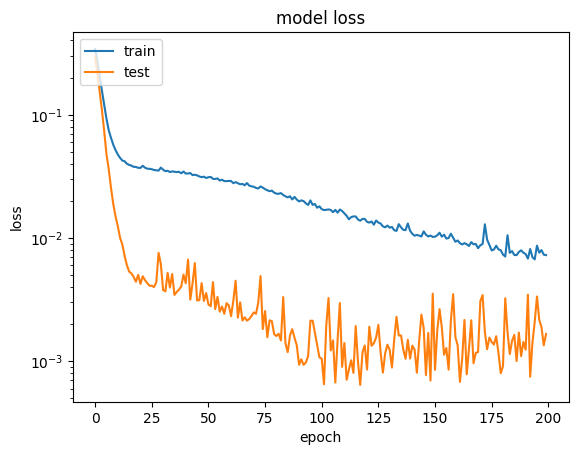

4/4 [==============================] - 0s 1ms/step


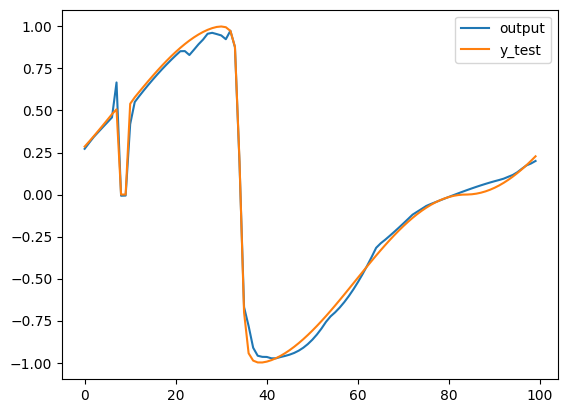

In [26]:
model = get_model(n_hidden_layers=2, n_neurons=10)
df_test = df_train[-100:]
df_train = df_train[:1500]
model, history = train_model(model, df_train, df_test, epochs=200)
visualize_training(history)
visualize_output(model, df_test)
model.save('model.h5')